# TCR Clonotypes

In [5]:
import sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [6]:
tcr_and_rna_combined = sc.read('/scratch/batch_corrected_umap.h5ad')

In [7]:
# We only select the cells that have TCR data
tcr_and_rna_combined = tcr_and_rna_combined[tcr_and_rna_combined.obs['has_tcr']=='True']

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [8]:
ir.pp.tcr_neighbors(tcr_and_rna_combined, receptor_arms="all", dual_tcr="primary_only")
# running this would add 'clonotype' and 'clonotyp_size' to the dataframe, which is important for clonotype expansion pipeline
ir.tl.define_clonotypes(tcr_and_rna_combined)

100%|██████████| 2177804/2177804 [00:17<00:00, 127099.15it/s]


In [9]:
ir.pp.tcr_neighbors(
    tcr_and_rna_combined,
    metric="alignment",
    sequence="aa",
    cutoff=5,
    receptor_arms="all",
    dual_tcr="all",
)

100%|██████████| 2380422/2380422 [00:16<00:00, 144176.74it/s]


In [10]:
ir.tl.define_clonotype_clusters(tcr_and_rna_combined, partitions="connected", sequence="aa", metric="alignment")

#### Just based on the clonotype network plot, primary tumor has far more varied clonotypes

In [52]:
ir.tl.clonotype_network(tcr_and_rna_combined, min_size=4, sequence="aa", metric="alignment")

array([<AxesSubplot:title={'center':'group'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

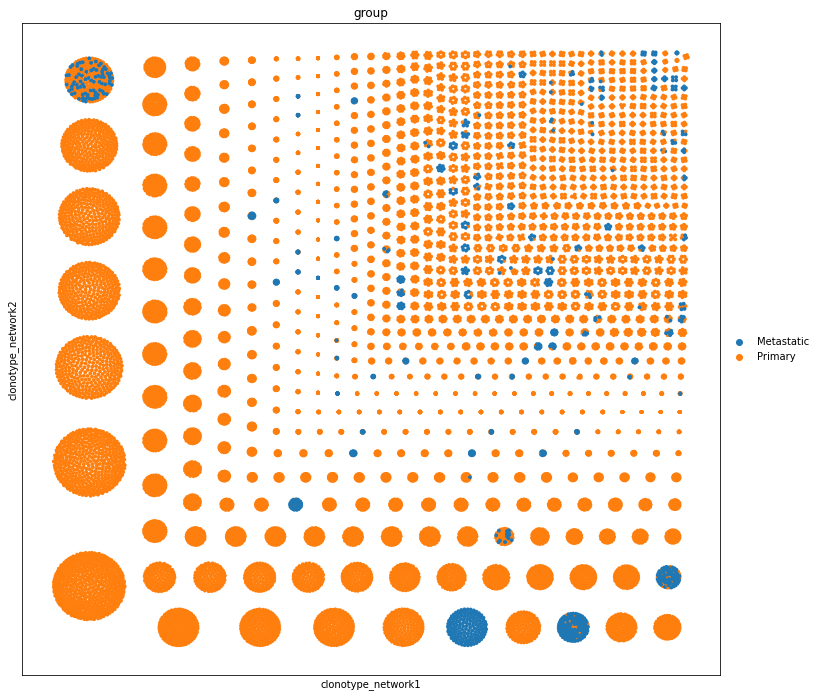

In [53]:
ir.pl.clonotype_network(tcr_and_rna_combined, color="group", size=60, panel_size=(12, 12))

#### It is not surprised to see that primary and metastatic tumor tissues provide common clonotypes, but it is very interesting that 295 and 314 actually have a lot in common in their clonotypes.

array([<AxesSubplot:title={'center':'sample'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

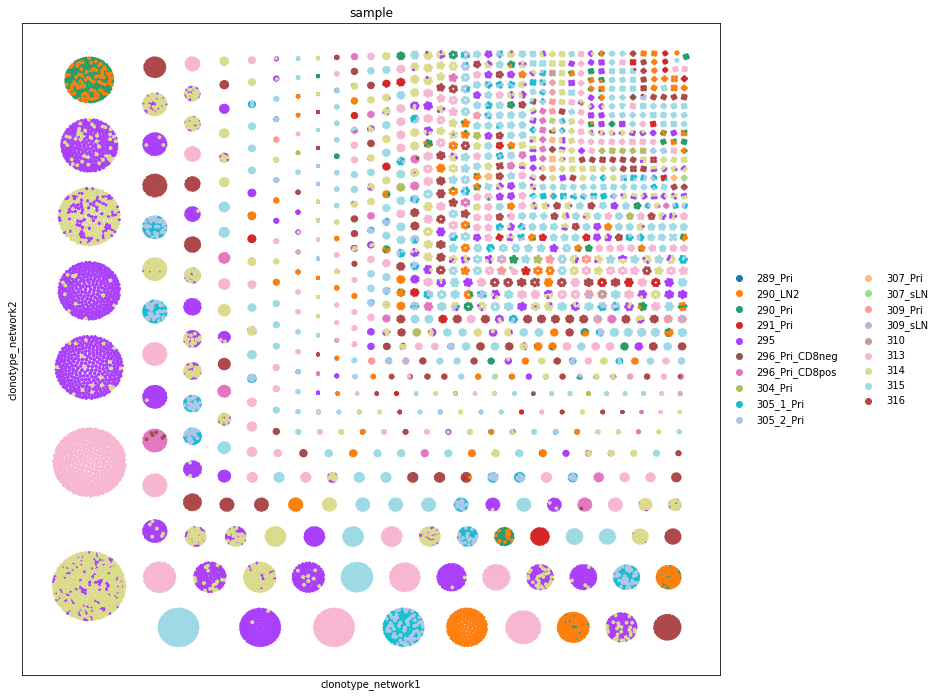

In [54]:
ir.pl.clonotype_network(tcr_and_rna_combined, color="sample", size=60, panel_size=(12, 12))

#### Examine information for clonotype cluster 4

# Clonotype Expansion

In [55]:
ir.tl.clonal_expansion(tcr_and_rna_combined,clip_at=5)

#### Most of the expanded clonotypes belong to the primary tumor group

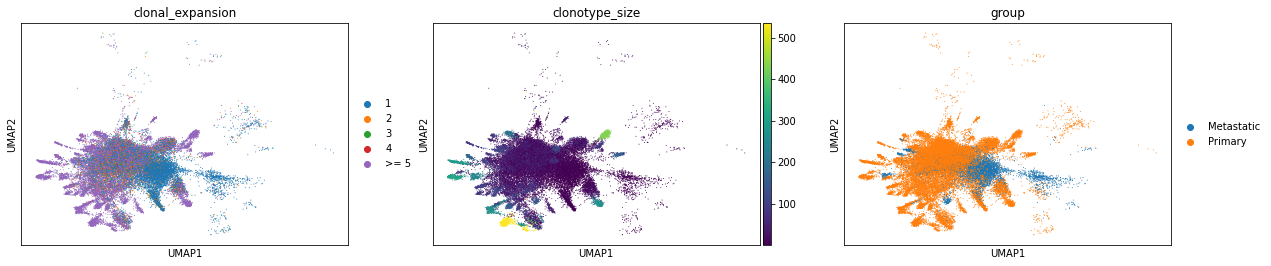

In [56]:
sc.pl.umap(tcr_and_rna_combined, color=['clonal_expansion','clonotype_size','group'])

#### The largest clonotypes belong to cluster 18 and cluster 35 both are T/NKT. 

#### The ratio of clonally expanded T-cells is also higher in primary tumor group

<AxesSubplot:>

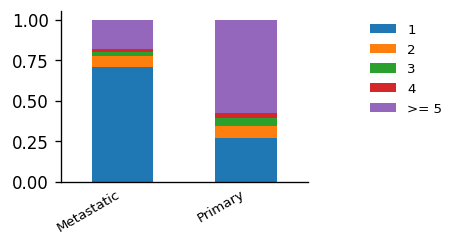

In [57]:
ir.pl.clonal_expansion(tcr_and_rna_combined, groupby='group', clip_at=5)

#### Batch-wise, the ratio of clonally expanded T-cells are not drastically different which is a good signal.

<AxesSubplot:>

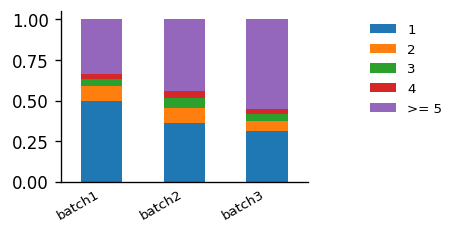

In [58]:
ir.pl.clonal_expansion(tcr_and_rna_combined, groupby='bat', clip_at=5)

<AxesSubplot:>

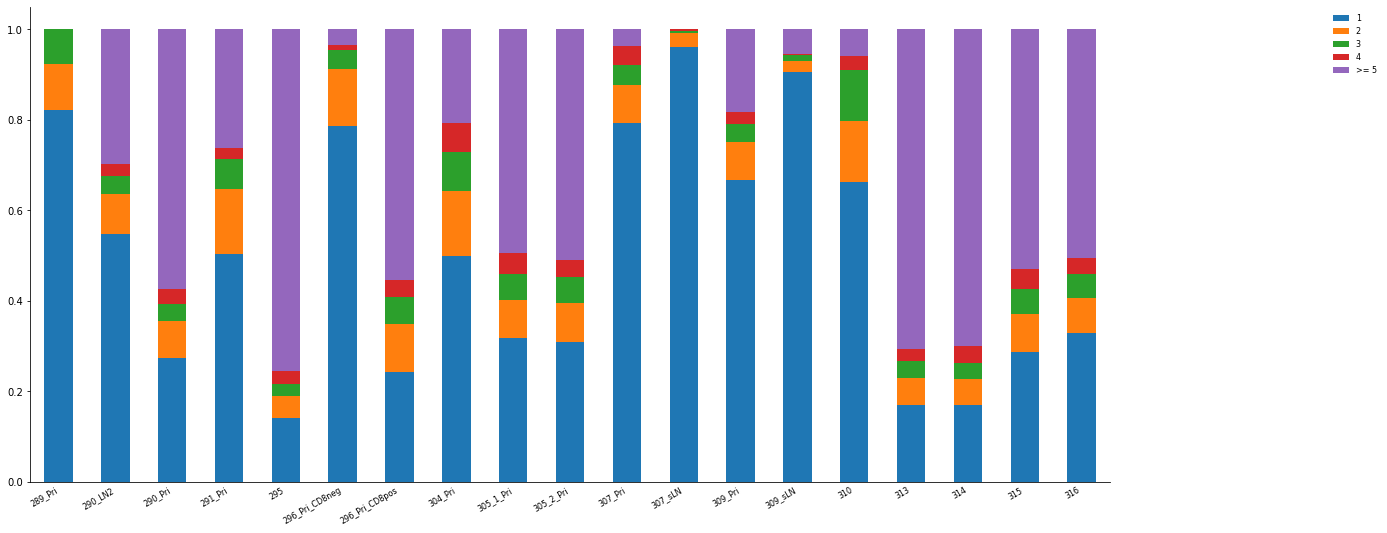

In [59]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(tcr_and_rna_combined, groupby='sample', clip_at=5,ax=ax)

<AxesSubplot:>

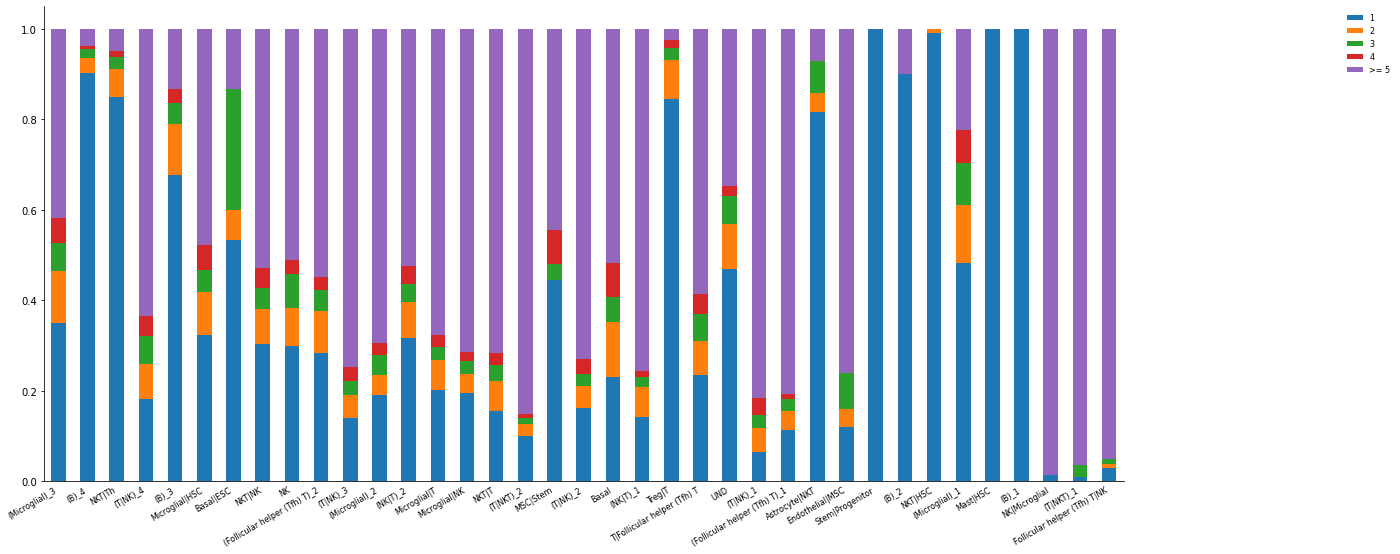

In [60]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(tcr_and_rna_combined, groupby='leiden', clip_at=5,ax=ax)

#### Clonotype frequency of primary tumor completely takes over 

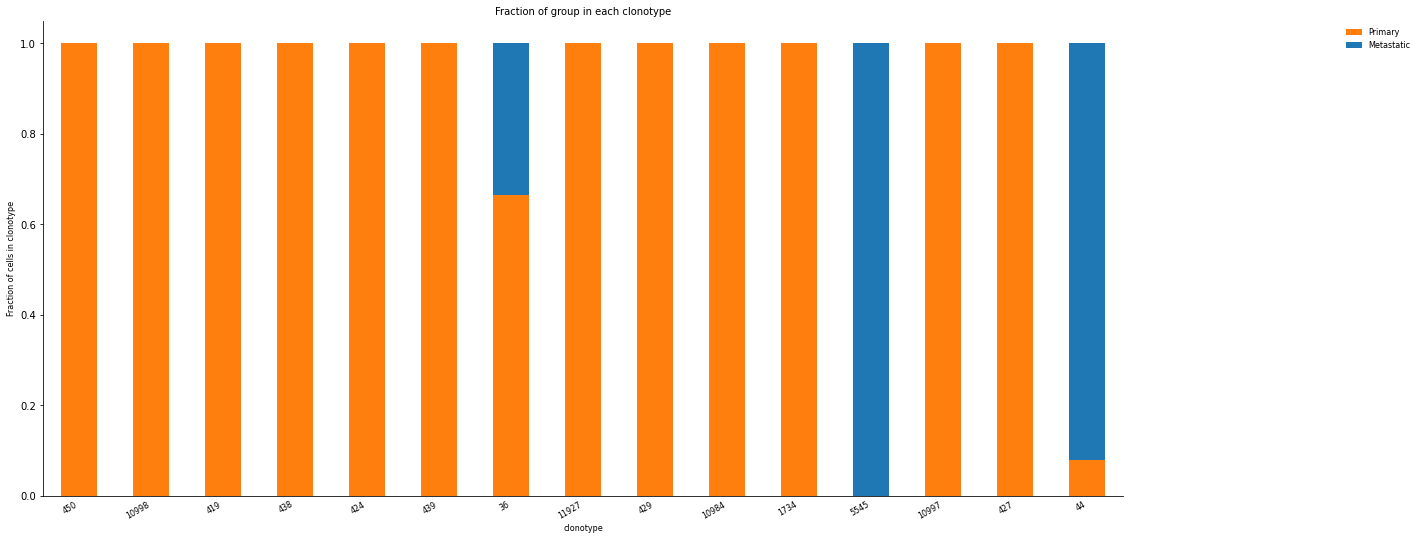

In [61]:
fig, ax = plt.subplots(figsize=(25, 12))
ax = ir.pl.group_abundance(tcr_and_rna_combined, groupby="clonotype", target_col="group", sort='count',max_cols=15,normalize='clonotype', fig_kws={"dpi": 100},ax=ax)

<AxesSubplot:title={'center':'Number of cells in clonotype by sample'}, xlabel='clonotype', ylabel='Number of cells'>

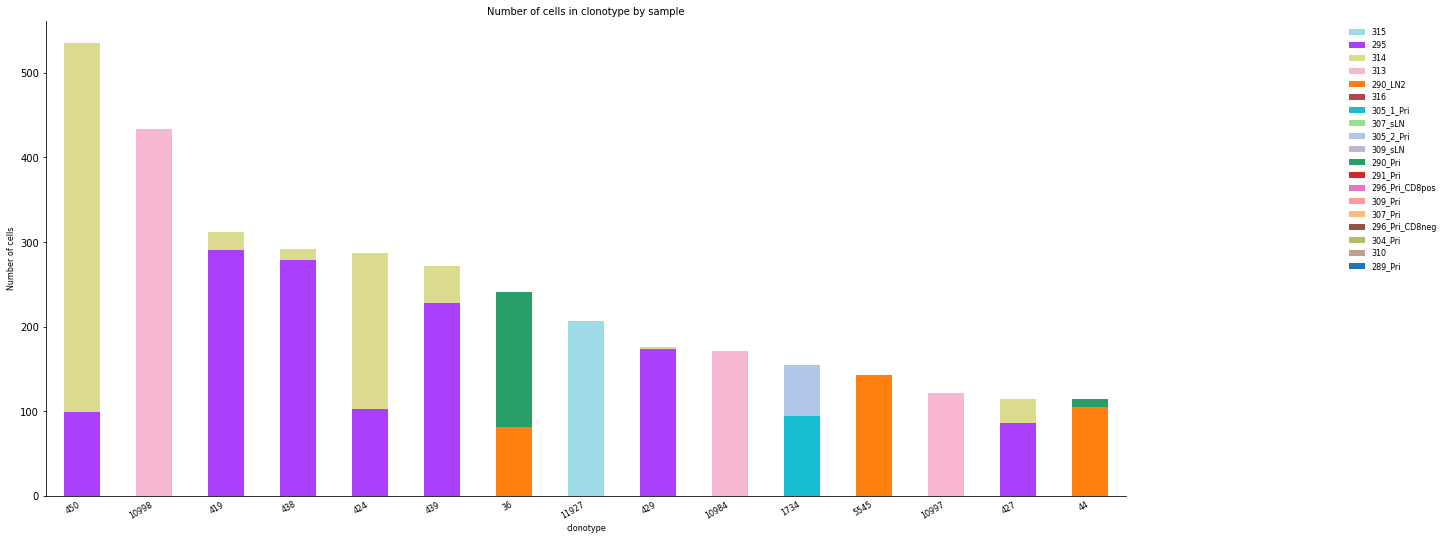

In [62]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(tcr_and_rna_combined, groupby="clonotype", target_col="sample",max_cols=15,ax=ax)

<AxesSubplot:title={'center':'Fraction of sample in each clonotype'}, xlabel='clonotype', ylabel='Fraction of cells in clonotype'>

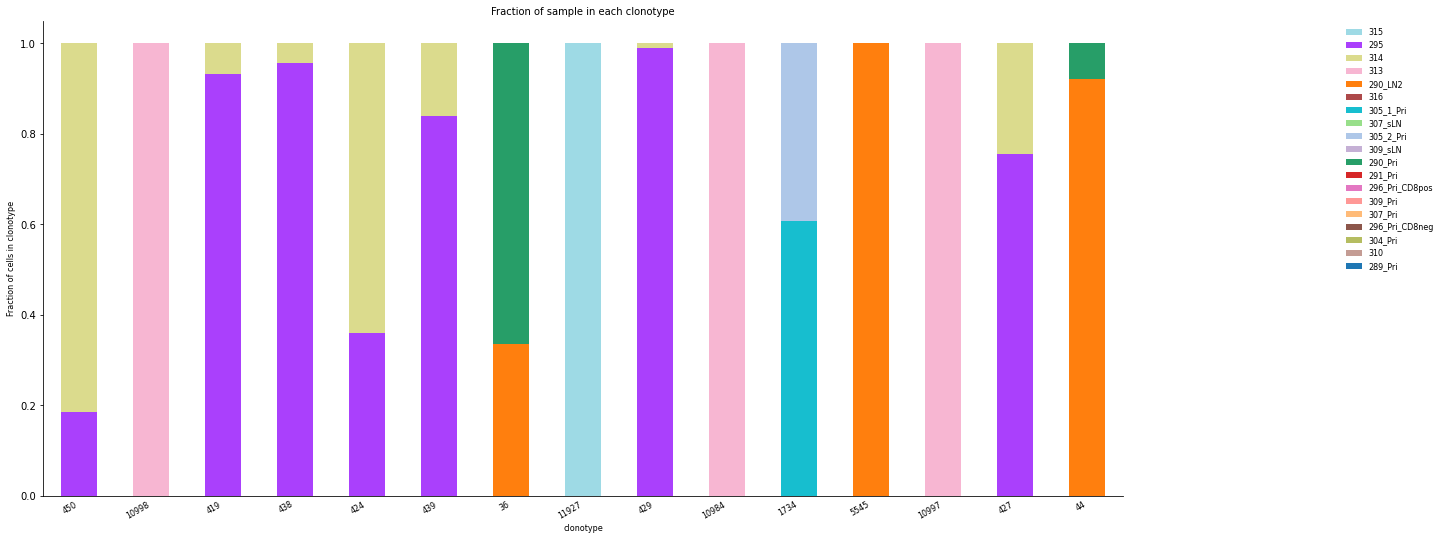

In [63]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(tcr_and_rna_combined, groupby='clonotype', normalize='clonotype',target_col='sample',max_cols=15,ax=ax)


#### We can extract clonotype information in more details

In [41]:
tcr_and_rna_combined.obs.loc[
    tcr_and_rna_combined.obs["ct_cluster_aa_alignment"] == "450",
    ["TRA_1_cdr3", "TRA_2_cdr3", "TRB_1_cdr3", "TRB_2_cdr3"],
]

,TRA_1_cdr3,TRA_2_cdr3,TRB_1_cdr3,TRB_2_cdr3
AAAGATGCATTGCGGC-1-2,CILRDGDLTSGNTPLVF,None,None,None
AACTTTCTCTCGTTTA-1-2,CILRDGDLTSGNTPLVF,None,None,None
AAGTCTGAGCGAAGGG-1-2,CILRDGDLTSGNTPLVF,None,None,None
ACACCAATCCACGACG-1-2,CILRDGDLTSGNTPLVF,None,None,None
ACACCGGTCTTGTTTG-1-2,CILRDGDLTSGNTPLVF,None,None,None
ACGGCCACAGACGCCT-1-2,CILRDGDLTSGNTPLVF,None,None,None
ACGTCAAGTCGTGGCT-1-2,CILRDGDLTSGNTPLVF,None,None,None
AGAATAGCAACCGCCA-1-2,CILRDGDLTSGNTPLVF,None,None,None
AGCGTCGAGATCTGAA-1-2,CILRDGDLTSGNTPLVF,None,None,None
AGCTCTCAGAGGACGG-1-2,CILRDGDLTSGNTPLVF,None,None,None


# Major Clonotypes Shift (not complete yet) 

In [42]:
#primary = tcr_and_rna_combined[tcr_and_rna_combined.obs['group']=='primary']
#metastatic = tcr_and_rna_combined[tcr_and_rna_combined.obs['group']=='metastatic']
#ir.pp.tcr_neighbors(primary, receptor_arms="all", dual_tcr="primary_only")

# running this would add 'clonotype' and 'clonotyp_size' to the dataframe, which is important for clonotype expansion pipeline
#ir.tl.define_clonotypes(primary)

#ir.pp.tcr_neighbors(metastatic, receptor_arms="all", dual_tcr="primary_only")
# running this would add 'clonotype' and 'clonotyp_size' to the dataframe, which is important for clonotype expansion pipeline
#ir.tl.define_clonotypes(metastatic)

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (32145×32145).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_nt_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (32145×32145).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['tcr_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (32145×32145).

These matrices should 

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [ ]:
#ir.tl.clonal_expansion(primary,clip_at=5)
#ir.tl.clonal_expansion(metastatic,clip_at=5)

In [ ]:
#fig, ax = plt.subplots(figsize=(25, 12))
#ir.pl.group_abundance(primary, groupby="clonotype", target_col="sample",max_cols=15,ax=ax)

# Repertoire Simiarity

In [64]:
df, dst, lk = ir.tl.repertoire_overlap(tcr_and_rna_combined, 'sample', inplace=False)

#### Primary and metastatic samples of the same patient are more closely related which is understandable. What's interesting in this plot is the high similarity between sample 295 and 314. This can also be seen from the clonotype network plot which shows that 295 and 314 do share a lot of common clonotypes.

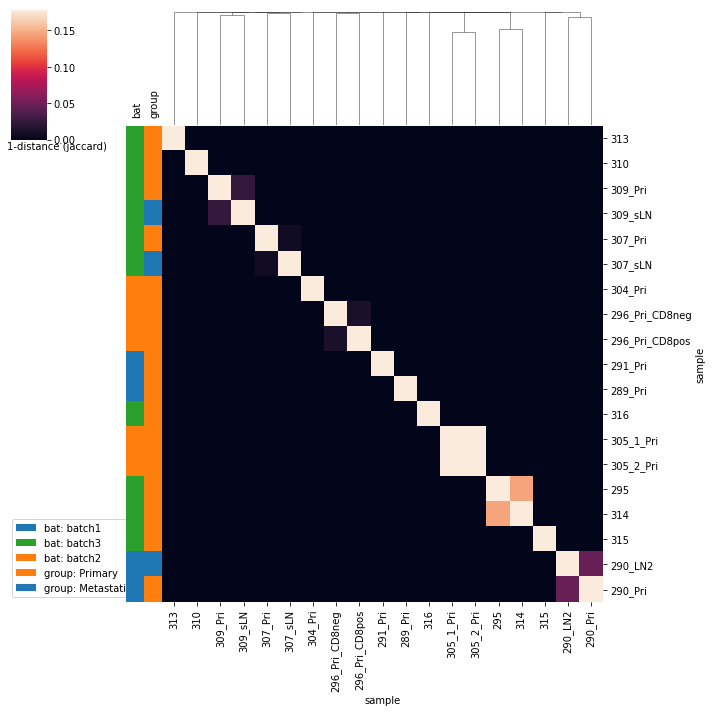

In [65]:
ir.pl.repertoire_overlap(tcr_and_rna_combined, 'sample', heatmap_cats=['bat', 'group'])

In [66]:
import pickle 
object = Object() 
filehandler = open(filename, 'w') 
pickle.dump(object, filehandler)

RuntimeError: Unable to create attribute (object header message is too large)

Above error raised while writing key 'uns/repertoire_overlap/weighted' of <class 'h5py._hl.files.File'> from /.